## Compare JacobiKAN, ChebyKAN's ability in function interpolation with MLP

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from ChebyKANLayer import ChebyKANLayer
from JacobiKANLayer import JacobiKANLayer

In [3]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    # add noise
    noise = np.random.normal(0, 0.2, y.shape)
    y += noise
    
    return y

In [13]:
# Define MLP and ChebyKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x-1) # centralize the input


class ChebyKAN(nn.Module):
    def __init__(self):
        super(ChebyKAN, self).__init__()
        self.chebykan1 = ChebyKANLayer(1, 8, 8)
        self.chebykan2 = ChebyKANLayer(8, 1, 8)

    def forward(self, x):
        x = self.chebykan1(x)
        x = self.chebykan2(x)
        return x
    
class JacobiKAN(nn.Module):
    def __init__(self):
        super(JacobiKAN, self).__init__()
        self.jacobikan1 = JacobiKANLayer(1, 8, 8)
        self.jacobikan2 = JacobiKANLayer(8, 1, 8)

    def forward(self, x):
        x = self.jacobikan1(x)
        x = self.jacobikan2(x)
        return x

In [14]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train))

# Instantiate models
jacobi_model = JacobiKAN()
cheby_model  = ChebyKAN()
mlp_model    = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_jacobi = torch.optim.Adam(jacobi_model.parameters(), lr=0.01)
optimizer_cheby  = torch.optim.Adam(cheby_model.parameters(), lr=0.01)
optimizer_mlp    = torch.optim.Adam(mlp_model.parameters(), lr=0.03)

jacobi_losses = []
cheby_losses = []
mlp_losses = []

# Train the models
epochs = 200000
for epoch in range(epochs):
    
    optimizer_jacobi.zero_grad()
    outputs_jacobi = jacobi_model(x_train)
    loss_jacobi = criterion(outputs_jacobi, y_train)
    loss_jacobi.backward()
    optimizer_jacobi.step()
    
    optimizer_cheby.zero_grad()
    outputs_cheby = cheby_model(x_train)
    loss_cheby = criterion(outputs_cheby, y_train)
    loss_cheby.backward()
    optimizer_cheby.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        jacobi_losses.append(loss_jacobi.item())
        cheby_losses.append(loss_cheby.item())
        mlp_losses.append(loss_mlp.item())
        print(f'Epoch {epoch + 1}/{epochs}, JacobiKAN Loss: {loss_jacobi.item():.4f}, ChebyKAN Loss: {loss_cheby.item():.4f}, MLP Loss: {loss_mlp.item():.4f}')



Epoch 1/200000, JacobiKAN Loss: 0.6893, ChebyKAN Loss: 0.5974, MLP Loss: 0.8758
Epoch 101/200000, JacobiKAN Loss: 0.1799, ChebyKAN Loss: 0.2243, MLP Loss: 0.2445
Epoch 201/200000, JacobiKAN Loss: 0.1751, ChebyKAN Loss: 0.1867, MLP Loss: 0.2430
Epoch 301/200000, JacobiKAN Loss: 0.1532, ChebyKAN Loss: 0.0761, MLP Loss: 0.2423
Epoch 401/200000, JacobiKAN Loss: 0.1286, ChebyKAN Loss: 0.0610, MLP Loss: 0.2415
Epoch 501/200000, JacobiKAN Loss: 0.1111, ChebyKAN Loss: 0.0556, MLP Loss: 0.2400
Epoch 601/200000, JacobiKAN Loss: 0.0926, ChebyKAN Loss: 0.0526, MLP Loss: 0.2368
Epoch 701/200000, JacobiKAN Loss: 0.0865, ChebyKAN Loss: 0.0522, MLP Loss: 0.2313
Epoch 801/200000, JacobiKAN Loss: 0.0821, ChebyKAN Loss: 0.0493, MLP Loss: 0.2299
Epoch 901/200000, JacobiKAN Loss: 0.0799, ChebyKAN Loss: 0.0472, MLP Loss: 0.2298
Epoch 1001/200000, JacobiKAN Loss: 0.0658, ChebyKAN Loss: 0.0452, MLP Loss: 0.2297
Epoch 1101/200000, JacobiKAN Loss: 0.0464, ChebyKAN Loss: 0.0444, MLP Loss: 0.2299
Epoch 1201/20000

KeyboardInterrupt: 

In [16]:
# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
y_pred_jacobi = jacobi_model(x_test).detach()
y_pred_cheby = cheby_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

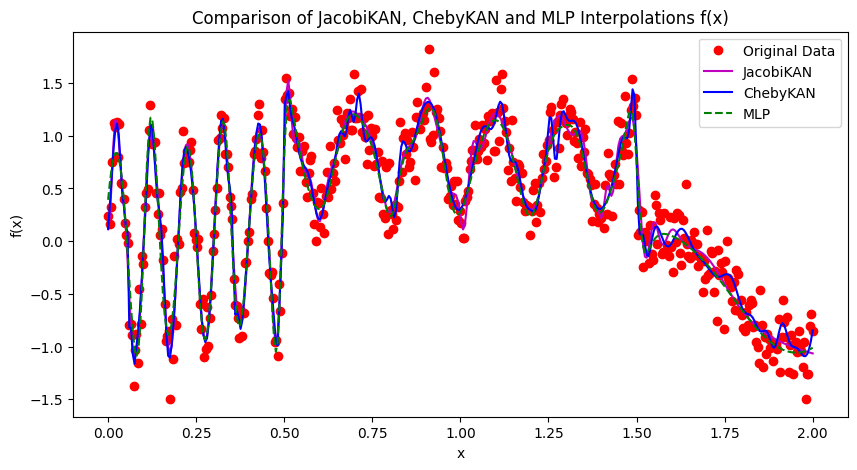

In [17]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data')
plt.plot(x_test.numpy(), y_pred_jacobi.numpy(), 'm-',  label='JacobiKAN')
plt.plot(x_test.numpy(), y_pred_cheby.numpy(),  'b-',  label='ChebyKAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(),    'g--', label='MLP')
plt.title('Comparison of JacobiKAN, ChebyKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

[0.03370726853609085, 0.0336097776889801, 0.03310897946357727, 0.038905274122953415, 0.032924167811870575, 0.03296234831213951, 0.03296121954917908, 0.03336793929338455, 0.03312428295612335, 0.033400289714336395, 0.04062631353735924, 0.03293052315711975, 0.03293830156326294, 0.037819501012563705, 0.03292983025312424, 0.037392549216747284, 0.03329870104789734, 0.03327649459242821, 0.03302503004670143, 0.03291711211204529, 0.032939329743385315, 0.034292541444301605, 0.03380732610821724, 0.03469478338956833, 0.03395209461450577, 0.047737158834934235, 0.034633032977581024, 0.03324718028306961, 0.034531790763139725, 0.03291423246264458, 0.03294692933559418, 0.03629564493894577, 0.03425334393978119, 0.033964257687330246, 0.03530997782945633, 0.03382711485028267, 0.03291255980730057, 0.03293871507048607, 0.032916534692049026, 0.03324809670448303, 0.03292136266827583, 0.03304040804505348, 0.032915182411670685, 0.03295017406344414, 0.03292013332247734, 0.033261995762586594, 0.03580085188150406,

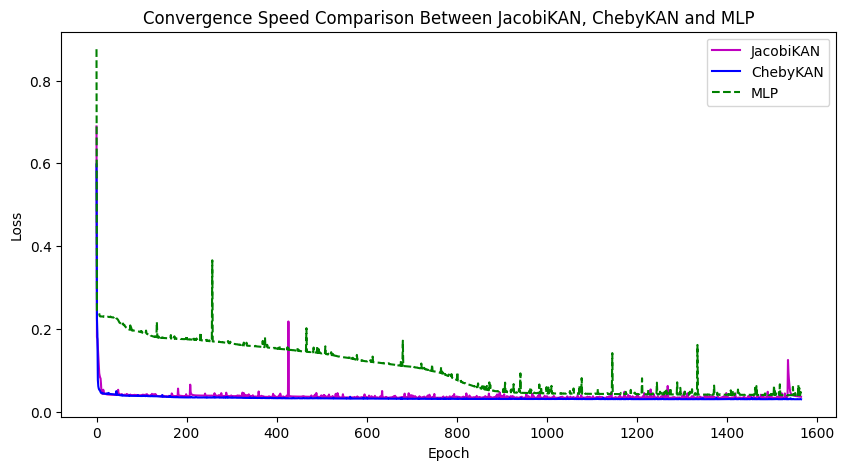

In [34]:
# Plot the convergence speed
# Plotting
plt.figure(figsize=(10, 5))
print(jacobi_losses[-100:])
jacobi_losses = [loss if loss < 1.0 else 0.038 for loss in jacobi_losses]
plt.plot(range(0, len(jacobi_losses), 1), jacobi_losses, 'm-',  label='JacobiKAN')
plt.plot(range(0, len(cheby_losses),  1),  cheby_losses, 'b-',   label='ChebyKAN')
plt.plot(range(0, len(mlp_losses),    1),    mlp_losses, 'g--',       label='MLP')
plt.title('Convergence Speed Comparison Between JacobiKAN, ChebyKAN and MLP')
# plt.xlim(-1000, len(jacobi_losses))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()